---
Title: Matching Chinese news title with English news title
parent: 2023 / 04 
Dataset: bloomberg_news_chinese_english 2016-03-01
---

### 0. Packages and functions

#### Import packages

In [1]:
# en python:
import os
os.environ["https_proxy"] = "http://proxy.fr.cfm.fr:6060"
#from nltk.tokenize import sent_tokenize
from datasets import Dataset
import numpy as np
import pandas as pd
import regex as re
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sentence_transformers import SentenceTransformer
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Help functions

In [15]:
import json
# read the config file into a dictionary
with open("/home/yzhong/notebooks/getting_started/config_transformer.json", "r") as f:
    config_ = json.load(f)

print(config_)

{'TRANSLATION_MODEL': 'Helsinki-NLP/opus-mt-zh-en', 'SENTENCE_TRANSFORMER': 'all-MiniLM-L6-v2', 'model_dir': '/opt/tmp/yzhong/models/'}


Functions for data cleaning

In [16]:
#remove space
def remove_space(text):
    text=text.replace(' ','')
    return text

#Full-width to half-width
def full_to_half(sentence):      
    change_sentence=""
    for word in sentence:
        inside_code=ord(word)
        if inside_code==12288:    #Direct conversion of full-width spaces
            inside_code=32
        elif inside_code>=65281 and inside_code<=65374:  #Full-width characters (except spaces) are converted according to the relationship
            inside_code-=65248
        change_sentence+=chr(inside_code)
    return change_sentence

# remove unnecessary symbols as well as things in paratheses     
def remove_special_chars(text):
    special_chars = r'[&*+\-\/<=>?@\^_|~]'
    # replace special characters with an empty string
    cleaned_text = re.sub(special_chars, '', text)
    pattern = r'\(.*?\)' # remove things in paratheses
    cleaned_text = re.sub(pattern, '', cleaned_text)
    return cleaned_text

    
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    #string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r'\(.*?\)', " \'d", string)
     # remove things in parathesesS
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()

In [99]:
def translate_p(text,tokenizer, model):
    """
    translate
    
    Args:
        batch ():
        tokenizer (Transformers.tokenizer):
        model (Transformers.model):
        
    Returns:
        The new dataset with a 'translation' column that have the translated text.
    """
    tokenized_batch = tokenizer(
        text,
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    with torch.no_grad():
        translation = model.generate(**tokenized_batch)
    return tokenizer.batch_decode(translation, skip_special_tokens=True)
    

In [17]:
def add_chinese_period (string):
    """
    For stablized the translation
    """
    string=string+'。'
    return string

Functions for applying transformer models

In [9]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" #cuda:0 indique que tu veux être sur le 1er GPU, cuda:1 le 2e
MODEL_ID = config_['TRANSLATION_MODEL']
tokenizer = AutoTokenizer.from_pretrained( MODEL_ID, use_fast=True, cache_dir=config_['model_dir'] )
model = AutoModelForSeq2SeqLM.from_pretrained( MODEL_ID, cache_dir=config_['model_dir'] ).to(device)

#batch_size : int = 256
#Prepare dataset
#ds = Dataset.from_dict(df_c)

In [6]:
import sys
print(sys.executable)
import torch
print(torch.__file__) 
print(torch.cuda.is_available())
from torch.utils import collect_env
print(collect_env.main())

/home/yzhong/conda/envs/yihan_gpu/bin/python
/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/torch/__init__.py
True
PyTorch version: 1.7.0
Is debug build: True
CUDA used to build PyTorch: 11.2
ROCM used to build PyTorch: N/A

OS: Red Hat Enterprise Linux Server 7.4 (Maipo) (x86_64)
GCC version: (GCC) 9.3.1 20200408 (Red Hat 9.3.1-2)
Clang version: Could not collect
CMake version: version 3.18.4

Python version: 3.8 (64-bit runtime)
Is CUDA available: True
CUDA runtime version: Could not collect
GPU models and configuration: 
GPU 0: Tesla V100-PCIE-16GB
GPU 1: Tesla V100-PCIE-16GB

Nvidia driver version: 460.27.04
cuDNN version: Probably one of the following:
/usr/local/cuda-11.2/targets/x86_64-linux/lib/libcudnn.so.8.2.1
/usr/local/cuda-11.2/targets/x86_64-linux/lib/libcudnn_adv_infer.so.8.2.1
/usr/local/cuda-11.2/targets/x86_64-linux/lib/libcudnn_adv_train.so.8.2.1
/usr/local/cuda-11.2/targets/x86_64-linux/lib/libcudnn_cnn_infer.so.8.2.1
/usr/local/cuda-11.2/targets/x86_

In [7]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION', )
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.8.11 (default, May  6 2022, 18:41:56) 
[GCC 9.3.1 20200408 (Red Hat 9.3.1-2)]
__pyTorch VERSION: 1.7.0
__CUDA VERSION
/bin/bash: nvcc: command not found
__CUDNN VERSION: 8201
__Number CUDA Devices: 2
__Devices
Active CUDA Device: GPU 0
Available devices  2
Current cuda device  0


In [8]:
import subprocess
def show_gpu(msg):
    """
    ref: https://discuss.pytorch.org/t/access-gpu-memory-usage-in-pytorch/3192/4
    """
    def query(field):
        return(subprocess.check_output(
            ['nvidia-smi', f'--query-gpu={field}',
                '--format=csv,nounits,noheader'], 
            encoding='utf-8'))
    def to_int(result):
        return int(result.strip().split('\n')[0])
    
    used = to_int(query('memory.used'))
    total = to_int(query('memory.total'))
    pct = used/total
    print('\n' + msg, f'{100*pct:2.1f}% ({used} out of {total})')    

In [9]:
show_gpu('Initial GPU memory usage:')


Initial GPU memory usage: 0.0% (4 out of 16160)


In [18]:
def translate(tokenizer, model,news='he is cute.'):
    """
    translate
    
    Args:
        batch ():
        tokenizer (Transformers.tokenizer):
        model (Transformers.model):
        
    Returns:
        The new dataset with a 'translation' column that have the translated text.
    """
    tokenized_batch = tokenizer(
        news,
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = { k:v.to(device) for k, v in tokenized_batch.items() if k in tokenizer.model_input_names }
    #mem_a = torch.cuda.memory_summary(device, True)
    

    with torch.no_grad():
        translation = model.generate(**inputs)
        
        output=tokenizer.batch_decode(translation, skip_special_tokens=True)
        translation.to('cpu')
        print(translation.device)
        
    return {
        'translation': output
    }

In [30]:
translate(tokenizer, model,news='他好可爱')

cuda:0


{'translation': ["He's so cute."]}

In [ ]:
MODEL_ID = config_['SENTENCE_TRANSFORMER']
model = SentenceTransformer(MODEL_ID,device='cuda',cache_folder=config_['model_dir'] )
# Use the map method to apply the mapping function to the dataset in batches
batch_size =256

In [19]:
#Calculate the length of the sentences so the batches will be patched efficiently
def compute_length(batch, text='headline'):
    """
    compute_length:
        Computes the length of a text (nb. of characters).
        
    Args:
        batch ():
        text (str): Which key gives the text.
    
    Returns:
        The new dataset with the length of the string of text.
    """
    return {
        'length': [len(item) for item in batch[text]]
    }

def translate(batch, tokenizer, model, text='headline'):
    """
    translate
    
    Args:
        batch ():
        tokenizer (Transformers.tokenizer):
        model (Transformers.model):
        
    Returns:
        The new dataset with a 'translation' column that have the translated text.
    """
    tokenized_batch = tokenizer(
        batch[text],
        padding="longest",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

    inputs = { k:v.to(device) for k, v in tokenized_batch.items() if k in tokenizer.model_input_names }

    with torch.no_grad():
        translation = model.generate(**inputs)
    return {
        'translation': tokenizer.batch_decode(translation, skip_special_tokens=True)
    }

def sentence_tokenization(batch, text='translation'):
    """
    Embeddings
    
    Args:
        batch ():
        
        model (Transformers.model):
        
    Returns:
        The new dataset with a 'embeddings' column that have the embeddings of the sentences.
    """
   # inputs = tokenizer(batch[text], padding= True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        embeddings = model.encode(batch[text])
    return {'embeddings': embeddings}

# Tokenization function for only one sentence
def sentence_tokenization_n(text):
   # inputs = tokenizer(batch[text], padding= True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        embeddings = model.encode(text)
    return torch.tensor(embeddings).unsqueeze(0)

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
#Start the multi-process pool on all available CUDA devices
pool = model.start_multi_process_pool()
def sentence_embedding(sentences):
    with torch.no_grad():
        emb = model.encode_multi_process(sentences, pool)
        model.stop_multi_process_pool(pool)
        print("Embeddings computed. Shape:", emb.shape)
    return {'embeddings': emb}

In [ ]:
if __name__ == '__main__':
    sentence_embedding('I love paris')

Function for calculating the cosinus similarity

In [20]:
# cosine similarity = normalize the vectors & multiply
#function via: https://stackoverflow.com/questions/66374955/computing-cosine-distance-with-differently-shaped-tensors
def cosinus_similarity (emb1, emb2):
# cosine similarity = normalize the vectors & multiply
    C = F.normalize(emb1) @ F.normalize(emb2).t()
    return C

Functions for plotting

In [46]:
def plot_hist(df,col='delay'):
    for j in range(3):
        plt.hist(df[f'{col}{j+1}'], bins=50, alpha=0.5, label=f'sim{j+1}')

    # plt.hist(df['delay1'], bins=50, alpha=0.5, label='Date1')
    # plt.hist(df['delay2'], bins=50, alpha=0.5, label='Date2')
    # plt.hist(df['delay3'], bins=50, alpha=0.5, label='Date3')
    # Add axis labels and a legend
    if col=='delay':
        label='Delay (minutes)'
        
    if col == 'cos':
        label='Cosinus similarity'
    title=f'Distribution of the {label} of the Chinese news with English news'

    plt.xlabel(label)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.legend()

    # Show the plot
    plt.show()


def plot_prob(df,col):
    hists=[None] * 3
    bin_edges=[None] * 3
    bin_centers=[None] * 3
    fig, ax = plt.subplots(figsize=(10, 5))
    for j in range(3):
        hists[j], bin_edges[j] = np.histogram(df[f'{col}{j+1}'], bins=50, density=True)
        bin_centers[j] = (bin_edges[j][:-1] + bin_edges[j][1:]) / 2
        ax.plot(bin_centers[j], hists[j], label=f'Sim{j+1}')
      
    # Add axis labels and a legend
    ax.set_xlabel(col)
    ax.set_ylabel('Probability density')
    ax.legend()

    # Show the plot
    plt.show()

### 1.  Prepare the dataset

#### Read Chinese dataset

In [23]:
#read the data for Chinese_english for 2016-03
df = pd.read_parquet("/home/yzhong/notebooks/getting_started/bloomberg_news_chinese.parquet")
df_c=df[df.language=='CHINESE_SIMP'] #prepare the dataframe for Chinese
df_c['headline_org']=df_c.loc[:,"headline"]
print(f'Chinese dataset:{df_c.shape}')

Chinese dataset:(1909052, 8)


/opt/tmp/tmp/ipykernel_291140/2804849642.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['headline_org']=df_c.loc[:,"headline"]


In [25]:
df_c.dropna(inplace=True)
df_c.reset_index(drop=True, inplace=True)
df_c=df_c.reset_index().rename(columns={'index': 'id'})
df_c=Process_clean(df_c, lg='zh')

/opt/tmp/tmp/ipykernel_291140/1722652315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.dropna(inplace=True)


In [ ]:
def read_english_df():
    

In [106]:
#read the data for Chinese_english for 2016-03
df = pd.read_parquet("bloomberg_news_chinese_english_2023.parquet")
df= df[df['date'].astype(str) ==  '2016-03-01'] #filtre the dataset only for one day --> test
df_c=df[df.language=='CHINESE_SIMP'] #prepare the dataframe for Chinese
df_c['headline_org']=df_c.loc[:,"headline"]
df_e=df[df.language=='ENGLISH'] #prepare the dataframe for English
print(f'English dataset: {df_e.shape}')
print(f'Chinese dataset:{df_c.shape}')

English dataset: (19208, 10)
Chinese dataset:(982, 11)


/opt/tmp/tmp/ipykernel_112435/420485590.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c['headline_org']=df_c.loc[:,"headline"]


In [107]:
# Drop rows with any NaN, NA or empty cells
df_e.dropna(inplace=True)
df_e.reset_index(drop=True, inplace=True)
df_c.dropna(inplace=True)
df_c.reset_index(drop=True, inplace=True)
print(f'English dataset after dropping NA: {df_e.shape}')
print(f'Chinese dataset after dropping NA: {df_c.shape}')

English dataset after dropping NA: (9924, 10)
Chinese dataset after dropping NA: (407, 11)


/opt/tmp/tmp/ipykernel_112435/1067274138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.dropna(inplace=True)
/opt/tmp/tmp/ipykernel_112435/1067274138.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_c.dropna(inplace=True)


In [108]:
#Add an id column on the dataset for future resorting and matching
df_e=df_e.reset_index().rename(columns={'index': 'id'})
df_c=df_c.reset_index().rename(columns={'index': 'id'})

#### Data cleaning

Clean the headline column so the text line does not contain strange symbols, for Chinese, also needs to remove the unnecessary space and turn Full-width to half-width. 

In [24]:
def Process_clean(df,lg='zh'):
    if lg=='zh': 
        df.loc[:,"headline"] = df.headline.apply(lambda x: full_to_half(x))
        df.loc[:,"headline"] = df.headline.apply(lambda x: add_chinese_period (x))

    df.loc[:,"headline"] = df.headline.apply(lambda x: remove_special_chars(x))
    if lg=='zh':
        df.loc[:,"headline"] = df.headline.apply(lambda x: remove_space(x))
    return df

Apply data cleaning on both Chinese and English dataset

In [110]:
df_c=Process_clean(df_c, lg='zh')
df_e=Process_clean(df_e, lg='en')

### 2. Translation Model

#### Create the model

In [26]:
device = "cuda:0" if torch.cuda.is_available() else "cpu" #cuda:0 indique que tu veux être sur le 1er GPU, cuda:1 le 2e
MODEL_ID = config_['TRANSLATION_MODEL']
tokenizer = AutoTokenizer.from_pretrained( MODEL_ID, use_fast=True, cache_dir=config_['model_dir'] )
model = AutoModelForSeq2SeqLM.from_pretrained( MODEL_ID, cache_dir=config_['model_dir'] ).to(device)

batch_size : int = 32
#Prepare dataset
ds = Dataset.from_dict(df_c)

In [112]:
# Load pre-trained model and tokenizer
model_name = "Helsinki-NLP/opus-mt-zh-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
batch_size : int = 10
#Prepare dataset
ds = Dataset.from_dict(df_c)

#### Apply translation model to dataset in batches

In [27]:
ds = ds.map(lambda x: compute_length(x, text='headline'), batched=True).sort('length', reverse=True)
ds = ds.map(lambda x: translate(x, tokenizer, model, text='headline'), batched=True, batch_size=batch_size).sort('id')

  0%|          | 0/1909 [00:00<?, ?ba/s]

  0%|          | 0/59655 [00:00<?, ?ba/s]

2023-04-12 13:34:17.212750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


#### Write results into file

In [28]:
ds.set_format("pandas")
df_c_t = ds[:]
df_c_t.to_parquet('/mnt/live/user/yzhong/bloomberg_news_chinese.parquet')

In [29]:
df_c_t=pd.read_parquet('/mnt/live/user/yzhong/bloomberg_news_chinese.parquet')

In [30]:
df_c_t.head()

,id,suid,last_update,language,analyst,date,headline,body,headline_org,length,translation
0,0,LJ6PWN6JIJVU,2011-04-05 15:05:11.901,CHINESE_SIMP,False,2011-04-05,彭博要闻。,\n下列为彭博今日要闻:\n\n商业\n1. 美联储主席伯南克说如果通胀持续上升 美联储将...,彭博要闻,5,Bloomberg highlights.
1,1,LJ7GAQ0UQVI9,2011-04-06 00:35:14.312,CHINESE_SIMP,False,2011-04-06,中国社科院研究员:今年通胀压力可能继续增强。,\n(更多新闻请点阅{TOP CS <GO>} {NH CBN <GO>})\n\n彭博新闻...,中国社科院研究员:今年通胀压力可能继续增强,22,"Researcher, Chinese Academy of Social Sciences..."
2,2,LJ7HVA6TTDTS,2011-04-06 01:09:10.927,CHINESE_SIMP,True,2011-04-06,"高盛维持中国重汽的中性评级:3808HK,MANGR。",--KEAN ZHANG\n\n-0- Apr/06/2011 01:09 GMT\n,"*高盛维持中国重汽的中性评级 :3808 HK, M...",27,Goldman Sachs maintains a neutral rating for h...
3,3,LJ7KAF6TTDSC,2011-04-06 02:01:27.382,CHINESE_SIMP,False,2011-04-06,亚洲开发银行发布2011年亚洲发展展望。,--KEAN ZHANG\n\n-0- Apr/06/2011 02:01 GMT\n,*亚洲开发银行发布2011年亚洲发展展望,20,The Asian Development Bank launched the Asian ...
4,4,LJ7LMP6TTDSF,2011-04-06 02:30:25.739,CHINESE_SIMP,False,2011-04-06,亚洲开发银行认为中国经济硬着陆的风险很小。,--KEAN ZHANG\n\n-0- Apr/06/2011 02:30 GMT\n,*亚洲开发银行认为中国经济硬着陆的风险很小,21,"According to the Asian Development Bank, the r..."


### 3. Similarity Model

#### Cleaning the data

An extra step of data cleaning need to be apply here to standarlize all the English texts.

In [117]:
df_c_t.loc[:,"translation"] = df_c_t.translation.apply(lambda x: clean_str(x))
df_e.loc[:,"headline"] = df_e.headline.apply(lambda x: clean_str(x))

#### Sentence embeddings

**Prepare the dataset**

In [118]:
ds_t = Dataset.from_dict(df_c_t)
ds_e = Dataset.from_dict(df_e)
ne=len(ds_e['headline'])
nt=len(ds_t['translation'])
print (f'English news: {ne}')
print (f'Chinese news: {nt}')

English news: 9924
Chinese news: 407


In [31]:
import glob

In [ ]:
file_list = glob.glob('/path/to/files/*.parquet')

In [ ]:
import pandas as pd

dfs = []
for file_path in file_list:
    df = pd.read_parquet(file_path)
    dfs.append(df)
full_df = pd.concat(dfs, axis=0)


**Prepare the model**

From the documentation: The all-mpnet-base-v2 model provides the best quality, while all-MiniLM-L6-v2 is 5 times faster and still offers good quality. Toggle All models to see all evaluated models or visit HuggingFace Model Hub to view all existing sentence-transformers models.
Link: https://www.sbert.net/docs/pretrained_models.html

In [119]:
model = SentenceTransformer('all-MiniLM-L6-v2',device='cuda')
# Use the map method to apply the mapping function to the dataset in batches
batch_size =256
ds_t = ds_t.map(lambda x: compute_length(x, text='translation'), batched=True).sort('length', reverse=True)
ds_t = ds_t.map(lambda x: sentence_tokenization(x , text='translation'), batched=True, batch_size=batch_size).sort('id')
ds_e = ds_e.map(lambda x: compute_length(x, text='headline'), batched=True).sort('length', reverse=True)
ds_e = ds_e.map(lambda x: sentence_tokenization(x, text='headline'), batched=True, batch_size=batch_size).sort('id')

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/41 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/993 [00:00<?, ?ba/s]

**Retrive the embeddings into tensors for both translated and English dataset**

In [120]:
translated_input_ids=ds_t['embeddings']
originated_input_ids=ds_e['embeddings']
emb1=torch.tensor(translated_input_ids)
emb2=torch.tensor(originated_input_ids)

### 4. Sentences matching

#### Calculate the similarity matrix

In [121]:
similarity_matrix=cosinus_similarity (emb1, emb2)

**Write the similarity matrix into numpy file**

In [122]:
# Save the matrix as a .npy file
np.save("cosine_similarities.npy", similarity_matrix)
# Save the matrix as a compressed .npz file
np.savez_compressed("cosine_similarities.npz", similarity_matrix )

In [123]:
# Load the .npy file
cosine_similarities = np.load("cosine_similarities.npy")
# Load the .npz file
with np.load("cosine_similarities.npz") as data:
    cosine_similarities = data["arr_0"]

#### Matching sentences in dataframe

**Get the indices**

In [124]:
# Get the indices that would sort each row in descending order
sorted_indices = np.argsort(-cosine_similarities, axis=1) # this will sort in descending values
# Get the indices of the top three values for each row
top_three_indices = sorted_indices[:, :3]

**Create a dataframe for the three closest neighbours of each sentence of translated Chinese headline**

In [125]:
# Create an empty dataframe to store the three closest neighbours for each sentences
sim_df = pd.DataFrame(columns=['id', 'Sim1', 'Sim2', 'Sim3', 'date1', 'date2', 'date3','cos1', 'cos2', 'cos3'])

# Loop over the rows of the `top_three_indices` array
for i, top_three in enumerate(top_three_indices):
    # Get the index of the current row
    index = i
    # Get the corresponding rows from `df_e`
    matches = df_e.loc[df_e['id'].isin(top_three)]
    matches = matches.reindex(index=top_three).reset_index(drop=True)
    
    # Create a new row to add to `result_df`
    new_row= {'id': index}
    
    # Loop over the matches and add their headlines and dates to the new row
    for j, match_row in matches.iterrows():
        new_row[f'Sim{j+1}'] = match_row['headline']
        new_row[f'date{j+1}'] = match_row['last_update']
        new_row[f'cos{j+1}'] = cosine_similarities[i][top_three[j]]
    
    # Add the new row to `sim_df`
    sim_df = sim_df.append(new_row, ignore_index=True)

**Merge the similarity dataframe with the original Chinese dataframe**

In [127]:
merged_df = pd.merge(df_c_t, sim_df, on='id')
merged_df.to_parquet('translated_similarity_2016_03_01.parquet')
df_sim=pd.read_parquet("translated_similarity_2016_03_01.parquet")

In [128]:
df_sim.head()

,id,suid,last_update,language,analyst,date,tickers,eqt_codes,topics,headline,...,translation,Sim1,Sim2,Sim3,date1,date2,date3,cos1,cos2,cos3
0,0,O3C40Q6K514T,2016-03-01 00:29:15.197,CHINESE_SIMP,False,2016-03-01,"VRX@CN, VRX@CN, VRX@CN, VRX@CN","BVF_CN, BVF_UN, BVF_CN, BVF_UN","ORIGINAL, LLTRANS, WORLD, US, SPREGIONS, BIZNE...",制药公司Valeant称正接受美国证券交易委员会调查股价大跌。,...,"valeant , a pharmaceutical company , claims th...",valeant loses about 75% of value since august,valeant at 3year low as more questions raised ...,valeant shares decline on news of sec investig...,2016-03-01 12:47:35.043,2016-03-01 16:05:32.934,2016-03-01 15:20:45.244,0.697822,0.680032,0.620034
1,1,O3C6DD7UT06G,2016-03-01 01:20:04.584,CHINESE_SIMP,False,2016-03-01,"2328@HK, 2328@HK, 2328@HK, 2328@HK, 2328@HK, 2...","2328_HK, 2328_R_HK, 2920_HK, 1136197D_HK, 2328...","MSCIDVAS, ACEXCLUDE, FIN, NASIA, EM, HEADS, WO...",中国财险股价在香港上涨3.6%报12.16港元。,...,china 's share in treasury policy increased by...,pacific basin shares rise 3.9% to hk$1.06 in h...,bank of china shares rise 1% to hk$2.94 in hon...,picc pc shares rise 3.6% to hk$12.16 in hong kong,2016-03-01 01:20:03.641,2016-03-01 01:20:01.193,2016-03-01 01:20:04.114,0.636367,0.629937,0.617045
2,2,O3C82J6TTDSS,2016-03-01 01:56:43.572,CHINESE_SIMP,False,2016-03-01,"1055@HK, 1055@HK, 1055@HK","1055_HK, 600029_CH, ZNH_UN","ACEXCLUDE, NASIA, EM, CHGOV, HEADS, POLIRISK, ...",财新:交通部副部长王昌顺获任中国南方航空集团总经理等职。,...,"fortune: wang changsoon , deputy minister of t...",china yuanbang prop: resignation of cfo co. se...,skyway sec names lin yuehe chairman,dongfang says current cfo chiu so charles name...,2016-03-01 10:48:49.394,2016-03-01 13:48:11.881,2016-03-01 03:12:16.656,0.513049,0.472731,0.470161
3,3,O3CCN46JTSEI,2016-03-01 03:35:28.578,CHINESE_SIMP,False,2016-03-01,"590@HK, 590@HK","590_HK, 590_HK","MSCIDVAS, ACEXCLUDE, NASIA, EM, RET, HEADS, FI...",六福集团在香港一度涨6.6%升抵1月4日来最高。,...,"at one point in hong kong , the six-favour gro...",picc group shares rise 2.5% to hk$2.88 in hong...,china huarong shares rise 1.8% to hk$2.88 in h...,dah chong hong final dividend 6.4 hk cents :18...,2016-03-01 01:20:02.156,2016-03-01 01:40:17.355,2016-03-01 08:20:52.823,0.561935,0.529554,0.528784
4,4,O3CEH26KLVRO,2016-03-01 04:15:02.636,CHINESE_SIMP,False,2016-03-01,"2314@HK, 2314@HK","2314_HK, 2314_HK","MSCIDVAS, ACEXCLUDE, NASIA, EM, HEADS, WORLD, ...",理文造纸派发末期股息每股9.5港仙。,...,an interest of 9.5 hong kong faires in the end...,lee man paper fy net hk$2.33b; est. hk$2.24b,lee man paper fy net hk$2.33b; est. hk$2.24b,lee man paper fy net hk$2.33b :2314 hk,2016-03-01 04:14:09.049,2016-03-01 04:17:31.501,2016-03-01 04:13:47.091,0.595156,0.595156,0.593677


**Write dataframe into a txt file**

In [129]:
with open('translated_similarity.txt', 'w') as f:
    for row in merged_df.itertuples():
        f.write(str(row.headline) + '\n')
        f.write(str(row.translation) + '\n')
        f.write(f' Sim1: {row.cos1}  {row.Sim1}' + '\n')
        f.write(f' Sim2: {row.cos2} {row.Sim2}' + '\n')
        f.write(f' Sim3: {row.cos3} {row.Sim3}' + '\n')

### 5. Statistics plot over the cosinus similarity

In [130]:
# Load your data into a pandas DataFrame
df = df_sim
# Convert columns to datetime type
df['last_update'] = pd.to_datetime(df['last_update'])
df['date1'] = pd.to_datetime(df['date1'])
df['date2'] = pd.to_datetime(df['date2'])
df['date3'] = pd.to_datetime(df['date3'])
# Calculate the delay in minutes between last_update and date1, date2, and date3
df['delay1'] = (df['last_update'] - df['date1']).dt.total_seconds() / 60
df['delay2'] = (df['last_update'] - df['date2']).dt.total_seconds() / 60
df['delay3'] = (df['last_update'] - df['date3']).dt.total_seconds() / 60

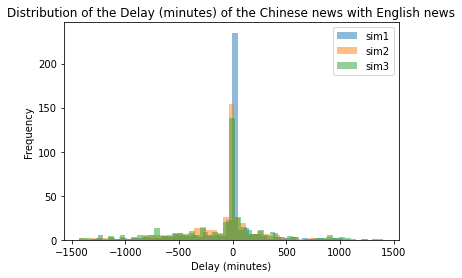

In [131]:
plot_hist(df,col='delay')

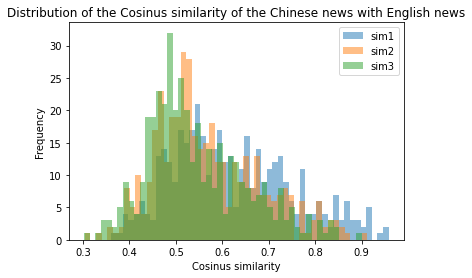

In [132]:
plot_hist(df,col='cos')

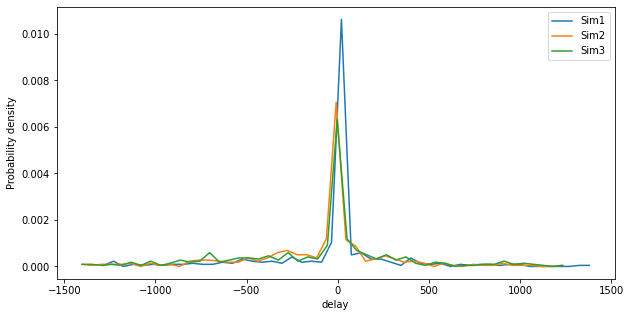

In [133]:
plot_prob(df,'delay')

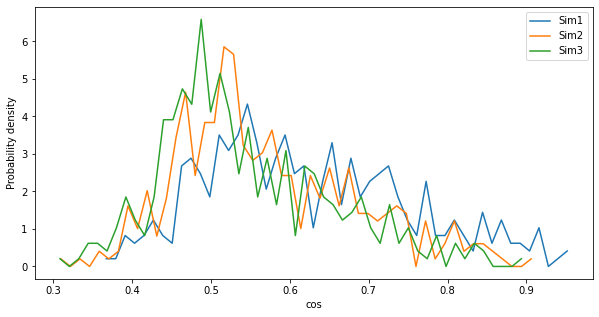

In [134]:
plot_prob(df,'cos')

Text(33.0, 0.5, 'Sentences')

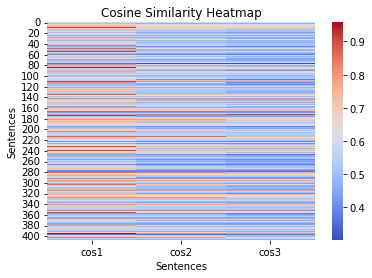

In [135]:
# Set threshold value
#thresh = 0.5
# create a new dataframe containing only the 'cos1', 'cos2', and 'cos3' columns
cols = ['cos1', 'cos2', 'cos3']
df_new = df_sim.loc[:, cols]
# Create heatmap using seaborn
sns.heatmap(df_new, cmap='coolwarm') #,vmin=0.3

# Set plot title and axis labels
plt.title('Cosine Similarity Heatmap')
plt.xlabel('Sentences')
plt.ylabel('Sentences')


### 6. Compare with the patterns

After evaluation of the data for 2016-03-01, the patterns that have been found for news that have English couterparties are the following: title starts with *, body contains 原文标题 'original title'. The objective of this part is to justify these patterns by comparing with the cosinus similarity.

In [137]:
def find_star (df):
    return ( df['headline_org'].str.contains(r'^\*[\u4e00-\u9fff0-9a-zA-Z].*'))

In [138]:
def get_TF(x, info_list):
    return any([True for i in info_list if i in str(x)])
    
def find_words(df, col_name='body', my_words=None):
    
    if my_words is None:
        my_words = ['原文标题','彭博自动新闻','原文標題']
        return (df[col_name].apply(lambda x: get_TF(x, my_words)))        

In [139]:
#df=df_sim.copy(deep=True)
mask1=find_star(df_sim)
mask2=find_words(df_sim)
df_sim['contains_star']=mask1
df_sim['contains_words']=mask2
df_sim['Only_Ch']= (~mask1) & (~mask2)

In [143]:
df_sim.to_parquet('pattern_compare_2016_03_01.parquet')
df=pd.read_parquet("pattern_compare_2016_03_01.parquet")

In [229]:
import seaborn as sns
import matplotlib.pyplot as plt
def Plot_cos_scatter(df, mask,cols=['cos1', 'cos2','cos3']):
    if mask:
        df_m=df[df[mask]==True]
        print(f"The number of news has {mask} pattern: {len(df_m)}, which is  {(len(df_m)/len(df))*100:.2f}% of the total news in Chinese")
    else: 
        df_m=df
    
    fig, axs = plt.subplots(ncols=len(cols), figsize=(16, 6))
    for col, ax  in zip(cols,axs.flatten()):
        max_value = df_m[col].max()
        min_value = df_m[col].min()
        mean_value = df_m[col].mean()
        print(f"Maximum value of {col}: {max_value}")
        print(f"Minimum value of {col}: {min_value}")
        print(f"Mean value of {col}: {mean_value}")
        df_m_c=df_m[df_m[col]<0.5]
        print(f"Percentage of the news that belows a similarity match of 0.5:  {(len(df_m_c)/len(df_m))*100:.2f}%")
    # Create the scatter plot
        ax.scatter(data=df_m, x='id', y=col,c=col, cmap='viridis') 

    # Add labels for the max, min, and mean values
        ax.text(df_m.index[df_m[col] == max_value][0], max_value, "Max", ha='center', va='center', fontsize=12, color='red')
        ax.text(df_m.index[df_m[col] == min_value][0], min_value, "Min", ha='center', va='center', fontsize=12, color='red')
        ax.text(df_m.index[int(len(df_m)/2)], mean_value, "Mean", ha='center', va='center', fontsize=12, color='red')
    
    # Add a text box with the max, min, and mean values
        ax.text(0.05, 0.95, f"Max: {max_value:.2f}\nMin: {min_value:.2f}\nMean: {mean_value:.2f}", transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  
    # Set the title and axis labels
        ax.set_title(f'Scatter plot of {col} for pattern {mask}')
        ax.set_xlabel('Index')
        ax.set_ylabel(col)
    
    
    plt.show()

The number of news has contains_star pattern: 314, which is  77.15% of the total news in Chinese
Maximum value of cos1: 0.9575899243354797
Minimum value of cos1: 0.38316091895103455
Mean value of cos1: 0.6400031082949061
Percentage of the news that belows a similarity match of 0.5:  14.65%
Maximum value of cos2: 0.9120166301727295
Minimum value of cos2: 0.3564889132976532
Mean value of cos2: 0.5811097615273895
Percentage of the news that belows a similarity match of 0.5:  24.52%
Maximum value of cos3: 0.8995128273963928
Minimum value of cos3: 0.3450985252857208
Mean value of cos3: 0.5545987023669443
Percentage of the news that belows a similarity match of 0.5:  35.99%


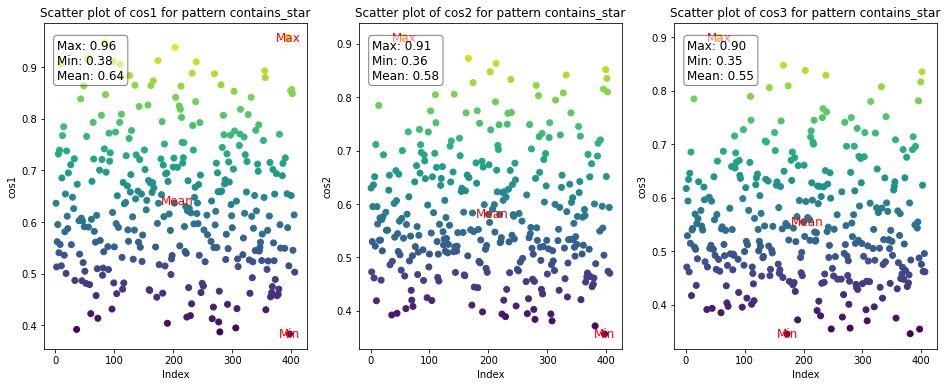

In [230]:
Plot_cos_scatter(df, 'contains_star')

The number of news has contains_words pattern: 45, which is  11.06% of the total news in Chinese
Maximum value of cos1: 0.8475528359413147
Minimum value of cos1: 0.4027712047100067
Mean value of cos1: 0.5967596279250251
Percentage of the news that belows a similarity match of 0.5:  20.00%
Maximum value of cos2: 0.8453056216239929
Minimum value of cos2: 0.3906424045562744
Mean value of cos2: 0.5580043541060553
Percentage of the news that belows a similarity match of 0.5:  28.89%
Maximum value of cos3: 0.8429293632507324
Minimum value of cos3: 0.3775477409362793
Mean value of cos3: 0.5239375703864627
Percentage of the news that belows a similarity match of 0.5:  55.56%


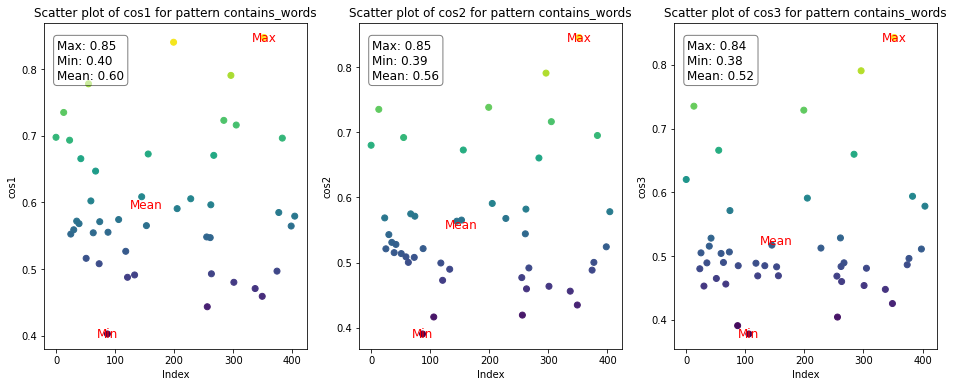

In [231]:
Plot_cos_scatter(df, 'contains_words')

The number of news has Only_Ch pattern: 48, which is  11.79% of the total news in Chinese
Maximum value of cos1: 0.8081537485122681
Minimum value of cos1: 0.3614223897457123
Mean value of cos1: 0.5364783381422361
Percentage of the news that belows a similarity match of 0.5:  31.25%
Maximum value of cos2: 0.8081537485122681
Minimum value of cos2: 0.30355867743492126
Mean value of cos2: 0.5094307425121466
Percentage of the news that belows a similarity match of 0.5:  52.08%
Maximum value of cos3: 0.7308989763259888
Minimum value of cos3: 0.3025815188884735
Mean value of cos3: 0.4946243980278571
Percentage of the news that belows a similarity match of 0.5:  56.25%


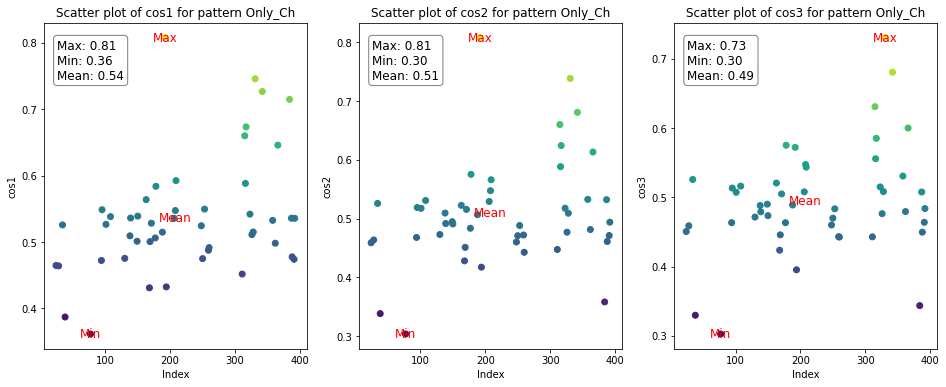

In [232]:
Plot_cos_scatter(df, 'Only_Ch')

Maximum value of cos1: 0.9575899243354797
Minimum value of cos1: 0.3614223897457123
Mean value of cos1: 0.6230125786045553
Percentage of the news that belows a similarity match of 0.5:  17.20%
Maximum value of cos2: 0.9120166301727295
Minimum value of cos2: 0.30355867743492126
Mean value of cos2: 0.5701015643610708
Percentage of the news that belows a similarity match of 0.5:  28.26%
Maximum value of cos3: 0.8995128273963928
Minimum value of cos3: 0.3025815188884735
Mean value of cos3: 0.5441355142897997
Percentage of the news that belows a similarity match of 0.5:  40.54%


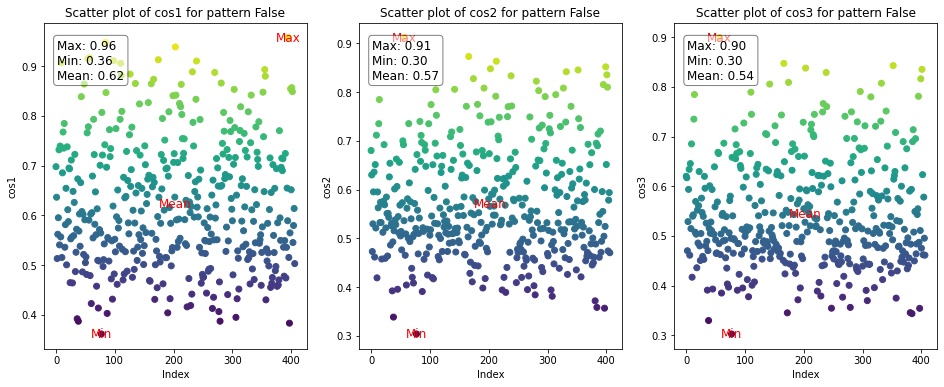

In [233]:
Plot_cos_scatter(df, mask=False)

In [ ]:
with open('english_headlines_2016_03_01.txt', 'w') as f:
    for row in df_e.itertuples():
        f.write(str(row.analyst) + '\n')
        f.write(str(row.last_update) + '\n')
        f.write(f'headline  {row.headline}' + '\n')

In [241]:
with open('pattern_check.txt', 'w') as f:
    for row in df_filter.itertuples():
        f.write(str(row.headline_org) + '\n')
        f.write(str(row.translation) + '\n')
        f.write(f' Sim1: {row.cos1}  {row.Sim1}' + '\n')
        f.write(f' Sim2: {row.cos2} {row.Sim2}' + '\n')
        f.write(f' Sim3: {row.cos3} {row.Sim3}' + '\n')
        f.write(f' Only chinese: {row.Only_Ch}' + '\n')
        f.write(f' Contain words: {row.contains_words}' + '\n')
 

In [244]:
df_filter2=df[df.Only_Ch==True]
with open('pattern_only_chinese_check.txt', 'w') as f:
    for row in df_filter2.itertuples():
        f.write(str(row.headline_org) + '\n')
        f.write(str(row.translation) + '\n')
        f.write(f' Sim1: {row.cos1}  {row.Sim1}' + '\n')
        f.write(f' Sim2: {row.cos2} {row.Sim2}' + '\n')
        f.write(f' Sim3: {row.cos3} {row.Sim3}' + '\n')


In [248]:
df_filter3=df[df.contains_star==True].sort_values(by=['cos1'], ascending=False)
with open('pattern_contains_star_check.txt', 'w') as f:
    for row in df_filter3.itertuples():
        f.write(str(row.headline_org) + '\n')
        f.write(str(row.translation) + '\n')
        f.write(f' Sim1: {row.cos1}  {row.Sim1}' + '\n')
        f.write(f' Sim2: {row.cos2} {row.Sim2}' + '\n')
        f.write(f' Sim3: {row.cos3} {row.Sim3}' + '\n')

In [249]:
df_filter4=df[df.contains_words==True].sort_values(by=['cos1'], ascending=False)
with open('pattern_contains_words_check.txt', 'w') as f:
    for row in df_filter4.itertuples():
        f.write(str(row.headline_org) + '\n')
        f.write(str(row.translation) + '\n')
        f.write(f' Sim1: {row.cos1}  {row.Sim1}' + '\n')
        f.write(f' Sim2: {row.cos2} {row.Sim2}' + '\n')
        f.write(f' Sim3: {row.cos3} {row.Sim3}' + '\n')

Delays 

In [2]:
import pandas as pd
df=pd.read_parquet("pattern_compare_2016_03_01.parquet")

/home/yzhong/conda/envs/yihan_env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [15]:
df_filter5=df[df['delay1'] >0].sort_values(by=['cos1'], ascending=False)

In [17]:
df_filter6=df_filter5.sort_values(by=['delay1'], ascending=True)

After observation, the news with a delay longer than 90 min and a cosinus smilarity score less than 0.55 are not matching correctly generally. In plus, a large part of these news are summerization news, which we are not interested. Therefore, a new mask will be created to filtre these news. 

In [40]:
def match(df):
    return ~( (abs(df['delay1'] )>90) & (df['cos1'] <0.55))

In [41]:
df['match']=match(df)

In [ ]:
with open('Delay_check.txt', 'w') as f:
    for row in df_filter5.itertuples():
        f.write(str(row.headline_org) + '\n')
        f.write(str(row.translation) + '\n')
        f.write(f' Sim1: {row.cos1}  {row.Sim1}' + '\n')
        f.write(f' Sim2: {row.cos2} {row.Sim2}' + '\n')
        f.write(f' Sim3: {row.cos3} {row.Sim3}' + '\n')

In [42]:
df[df['match']==False].headline

2                 财新:交通部副部长王昌顺获任中国南方航空集团总经理等职。
24           观点综述:美国制造业颓势放缓;德拉吉称欧元区经济面临更大下行风险。
28              中国债市观察:央行降准后暂停逆回购市场淡定应对焦点转向利率。
33             兴业证券截至29日回购股份占公司目前总股本的比例为0.71%。
34            中国汇市:人民币上涨降准首日中资行有护盘迹象;中美央行高端对话。
                        ...                   
389            陈雨露:新兴市场经济如果无法解决货币错配问题可能引发金融风险。
391    中国债市:IRS跌;公开市场暂停;中信建投坚持10年国债2.5%为阶段性目标。
392              中国大陆股市更新:上证综合指数几乎持平2,695.52点。
396                            蓝天威力6828正面盈利预告。
397                         腾讯与宏盟媒体集团联手创新数据营销。
Name: headline, Length: 91, dtype: object

In [43]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Create the confusion matrices
confusion_star = confusion_matrix(df['match'], df['contains_star'])
confusion_words = confusion_matrix(df['match'], df['contains_words'])
confusion_ch = confusion_matrix(df['match'], df['Only_Ch'])

# Calculate the percentages of each case
confusion_star_perc = confusion_star / confusion_star.sum()
confusion_words_perc = confusion_words / confusion_words.sum()
confusion_ch_perc = confusion_ch / confusion_ch.sum()

# Print the confusion matrices with percentages
print("Confusion Matrix for 'contains_star' vs 'match':")
print(confusion_star_perc)

print("Confusion Matrix for 'contains_words' vs 'match':")
print(confusion_words_perc)

print("Confusion Matrix for 'Only_Ch' vs 'match':")
print(confusion_ch_perc)

Confusion Matrix for 'contains_star' vs 'match':
[[0.10565111 0.11793612]
 [0.12285012 0.65356265]]
Confusion Matrix for 'contains_words' vs 'match':
[[0.19164619 0.03194103]
 [0.6977887  0.07862408]]
Confusion Matrix for 'Only_Ch' vs 'match':
[[0.14987715 0.07371007]
 [0.73218673 0.04422604]]


In [44]:
# Print the confusion matrices with numbers and percentages
print("Confusion Matrix for 'contains_star' vs 'match':")
print(confusion_star)
print(confusion_star_perc)

print("Confusion Matrix for 'contains_words' vs 'match':")
print(confusion_words)
print(confusion_words_perc)

print("Confusion Matrix for 'Only_Ch' vs 'match':")
print(confusion_ch)
print(confusion_ch_perc)

Confusion Matrix for 'contains_star' vs 'match':
[[ 43  48]
 [ 50 266]]
[[0.10565111 0.11793612]
 [0.12285012 0.65356265]]
Confusion Matrix for 'contains_words' vs 'match':
[[ 78  13]
 [284  32]]
[[0.19164619 0.03194103]
 [0.6977887  0.07862408]]
Confusion Matrix for 'Only_Ch' vs 'match':
[[ 61  30]
 [298  18]]
[[0.14987715 0.07371007]
 [0.73218673 0.04422604]]


In [50]:
confusion_star

array([[ 43,  48],
       [ 50, 266]])

In [53]:
confusion_star_perc = confusion_star / confusion_star.sum()
type(confusion_star_perc[0][0])

numpy.float64

In [62]:
len(df[df.contains_words]==True)

45

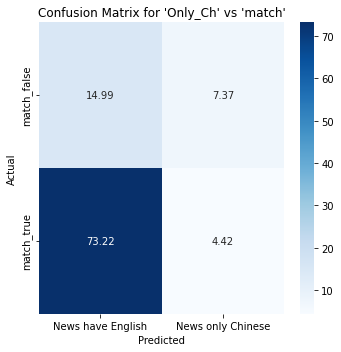

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
#confusion_star = confusion_matrix(df['match'], df['contains_star'])
#confusion_words = confusion_matrix(df['match'], df['contains_words'])
confusion_ch = confusion_matrix(df['match'], df['Only_Ch'])

# Calculate the percentages of each case
#confusion_star_perc = confusion_star / len(df) * 100
#confusion_words_perc = confusion_words / len(df) * 100
confusion_ch_perc = confusion_ch / len(df) * 100

# Create a list of column names for the confusion matrices
columns = ['match_false', 'match_true']
#column_star = ['contains_star_false', 'contains_star_true']
#column_words = ['contains_words_false', 'contains_words_true']
column_Ch = ['News have English', 'News only Chinese']

# Create the subplots
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the confusion matrix for 'contains_star'
# sns.heatmap(confusion_star_perc, annot=True, fmt='.2f', cmap='Blues', ax=axes[0])
# axes[0].set_title("Confusion Matrix for 'contains_star' vs 'match'")
# axes[0].set_xlabel("Predicted")
# axes[0].set_ylabel("Actual")
# axes[0].set_xticklabels(column_star)
# axes[0].set_yticklabels(columns)

# Plot the confusion matrix for 'contains_words'
# sns.heatmap(confusion_words_perc, annot=True, fmt='.2f', cmap='Blues', ax=axes[1])
# axes[1].set_title("Confusion Matrix for 'contains_words' vs 'match'")
# axes[1].set_xlabel("Predicted")
# axes[1].set_ylabel("Actual")
# axes[1].set_xticklabels(column_words)
# axes[1].set_yticklabels(columns)

# Plot the confusion matrix for 'Only_Ch'
sns.heatmap(confusion_ch_perc, annot=True, fmt='.2f', cmap='Blues')
ax.set_title("Confusion Matrix for 'Only_Ch' vs 'match'")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticklabels(column_Ch)
ax.set_yticklabels(columns)

plt.tight_layout()
plt.show()


maybe we can then create a filtre for the sumarize news and leave news that have values 

In [35]:
with open('bad_matches.txt', 'w') as f:
    for row in df_filter6.itertuples():
        f.write(str(row.headline_org) + '\n')
        f.write(str(row.translation) + '\n')
 

In [77]:
df.to_parquet('pattern_compare_2016_03_01.parquet')
df=pd.read_parquet("pattern_compare_2016_03_01.parquet")

In [78]:
df

,id,suid,last_update,language,analyst,date,tickers,eqt_codes,topics,headline,...,cos1,cos2,cos3,delay1,delay2,delay3,contains_star,contains_words,Only_Ch,match
index,,,,,,,,,,,,,,,,,,,,,
0,0,O3C40Q6K514T,2016-03-01 00:29:15.197,CHINESE_SIMP,False,1456790400000000000,"VRX@CN, VRX@CN, VRX@CN, VRX@CN","BVF_CN, BVF_UN, BVF_CN, BVF_UN","ORIGINAL, LLTRANS, WORLD, US, SPREGIONS, BIZNE...",制药公司Valeant称正接受美国证券交易委员会调查股价大跌。,...,0.697822,0.680032,0.620034,-738.330767,-936.295617,-891.500783,False,True,False,True
1,1,O3C6DD7UT06G,2016-03-01 01:20:04.584,CHINESE_SIMP,False,1456790400000000000,"2328@HK, 2328@HK, 2328@HK, 2328@HK, 2328@HK, 2...","2328_HK, 2328_R_HK, 2920_HK, 1136197D_HK, 2328...","MSCIDVAS, ACEXCLUDE, FIN, NASIA, EM, HEADS, WO...",中国财险股价在香港上涨3.6%报12.16港元。,...,0.636367,0.629937,0.617045,0.015717,0.056517,0.007833,True,False,False,True
2,2,O3C82J6TTDSS,2016-03-01 01:56:43.572,CHINESE_SIMP,False,1456790400000000000,"1055@HK, 1055@HK, 1055@HK","1055_HK, 600029_CH, ZNH_UN","ACEXCLUDE, NASIA, EM, CHGOV, HEADS, POLIRISK, ...",财新:交通部副部长王昌顺获任中国南方航空集团总经理等职。,...,0.513049,0.472731,0.470161,-532.097033,-711.471817,-75.551400,True,False,False,False
3,3,O3CCN46JTSEI,2016-03-01 03:35:28.578,CHINESE_SIMP,False,1456790400000000000,"590@HK, 590@HK","590_HK, 590_HK","MSCIDVAS, ACEXCLUDE, NASIA, EM, RET, HEADS, FI...",六福集团在香港一度涨6.6%升抵1月4日来最高。,...,0.561935,0.529554,0.528784,135.440367,115.187050,-285.404083,True,False,False,True
4,4,O3CEH26KLVRO,2016-03-01 04:15:02.636,CHINESE_SIMP,False,1456790400000000000,"2314@HK, 2314@HK","2314_HK, 2314_HK","MSCIDVAS, ACEXCLUDE, NASIA, EM, HEADS, WORLD, ...",理文造纸派发末期股息每股9.5港仙。,...,0.595156,0.595156,0.593677,0.893117,-2.481083,1.259083,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
402,402,O3DP3QSYF01T,2016-03-01 21:02:14.541,CHINESE_SIMP,False,1456790400000000000,"GOOGL, GOOGL, GOOG, GOOG, AAPL, GOOG, GOOG, AAPL","GOOG_UQ, GOOCV_US, GOOG_UQ, GOOCV_US, AAPL_UQ,...","CRIME, METALKEY, ELE, ACEXCLUDE, ALLSTATES, RE...",苹果法律顾问:公司对恐怖分子毫无同情。,...,0.848728,0.810017,0.623317,0.521217,-33.177750,-21.200850,True,False,False,True
403,403,O3DV4W6K50YL,2016-03-01 23:12:32.871,CHINESE_SIMP,False,1456790400000000000,"300502@CH, 300502@CH","300502_CH, 300502_CH","ELE, COEVNT, ACEXCLUDE, NASIA, EM, HEADS, FIRS...",新易盛将于3月3日在深圳上市。,...,0.545301,0.474014,0.461979,0.624300,557.544283,42.522667,True,False,False,True
404,404,O3DWKW6KLVRB,2016-03-01 23:43:44.381,CHINESE_SIMP,False,1456790400000000000,"SAB@LN, SAB@LN, 291@HK, 291@HK, 291@HK, ABI@BB...","SAB_LN, SAB_SJ, 0291_HK, 0291_R_HK, 1427210D_H...","COEVNT, MSCIDVAS, ORIGINAL, NASIA, EM, CHGOV, ...",华润啤酒同意以16亿美元购入华润雪花啤酒49%的股权。,...,0.579527,0.578144,0.578144,11.777767,10.764367,10.453333,False,True,False,True
